In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
labels = pd.read_csv("../label_names.csv")
labels.head()

,label_id,label_name
0,0,Games
1,1,Vehicle
2,2,Video game
3,3,Concert
4,4,Car


In [4]:
videos = pd.read_csv("../train_labels.csv", header=None)
videos.head()

,0,1
0,--DwgB78t-c,16 5 430
1,--NZRkXBV7k,128 3 39 7 44 13 16 30
2,--hoQ2sGG4M,694
3,--ABhs9ik7c,2232 1 4 517 270
4,--sBoaqBlzA,45 125


In [5]:
videos.columns = ['video_id', 'labels']
videos.head()

,video_id,labels
0,--DwgB78t-c,16 5 430
1,--NZRkXBV7k,128 3 39 7 44 13 16 30
2,--hoQ2sGG4M,694
3,--ABhs9ik7c,2232 1 4 517 270
4,--sBoaqBlzA,45 125


Counting labels

In [6]:
from collections import Counter
from itertools import chain

In [7]:
separated = videos['labels'].apply(lambda x: x.split(" "))
separated.head()

0                       [16, 5, 430]
1    [128, 3, 39, 7, 44, 13, 16, 30]
2                              [694]
3             [2232, 1, 4, 517, 270]
4                          [45, 125]
Name: labels, dtype: object

In [8]:
all_labels = list(chain.from_iterable(separated))
all_labels[:10]

['16', '5', '430', '128', '3', '39', '7', '44', '13', '16']

In [9]:
labels_count = Counter(all_labels)
labels_count.most_common(10)

[('0', 859519),
 ('1', 678257),
 ('2', 518981),
 ('3', 494707),
 ('4', 371391),
 ('5', 303295),
 ('6', 296624),
 ('7', 295199),
 ('8', 217920),
 ('9', 214887)]

In [10]:
col_counts = labels['label_id'].apply(lambda x: labels_count[str(x)])
col_counts[:10]

0    859519
1    678257
2    518981
3    494707
4    371391
5    303295
6    296624
7    295199
8    217920
9    214887
Name: label_id, dtype: int64

In [11]:
labels['count'] = col_counts
labels.head()

,label_id,label_name,count
0,0,Games,859519
1,1,Vehicle,678257
2,2,Video game,518981
3,3,Concert,494707
4,4,Car,371391


Plot the top 15 labels

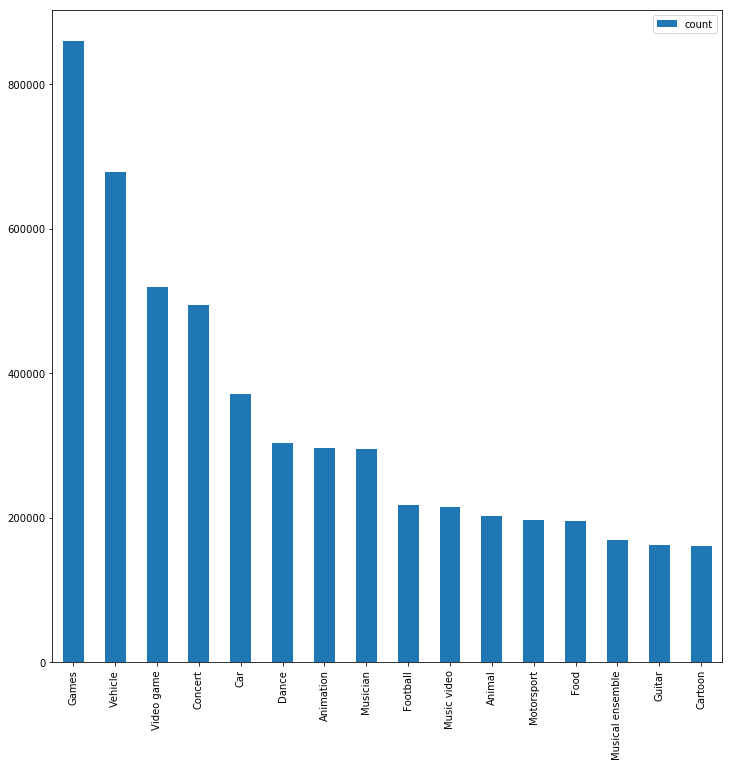

In [12]:
labels.ix[:15, 1:].plot.bar(figsize=(12, 12))
plt.xticks(range(16), labels.ix[:15, 1], rotation='vertical')
plt.show()

In [13]:
others = np.sum(labels['count'][16:])
print(others)

11301584


In [52]:
top_labels = labels.ix[:15, :]

In [53]:
top_labels.loc[16, :] = [16, 'Others', others]

/home/mithrillion/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


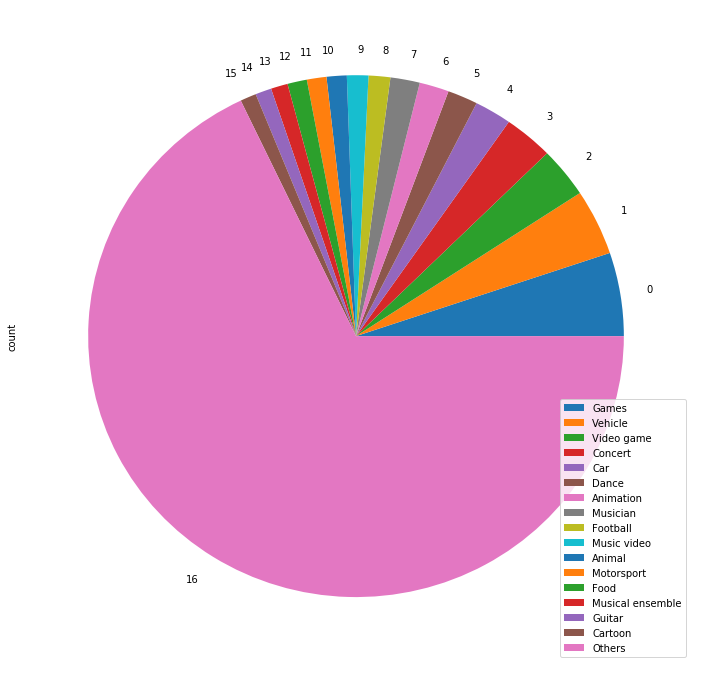

In [55]:
ax = top_labels.plot.pie(y='count', figsize=(12, 12))
plt.legend(loc='lower right', labels=top_labels['label_name'])
plt.show()

Now we look at co-occurence of labels

In [17]:
videos.head()

,video_id,labels
0,--DwgB78t-c,16 5 430
1,--NZRkXBV7k,128 3 39 7 44 13 16 30
2,--hoQ2sGG4M,694
3,--ABhs9ik7c,2232 1 4 517 270
4,--sBoaqBlzA,45 125


In [18]:
labels.shape

(4716, 3)

In [19]:
N_LABELS = labels.shape[0]

In [20]:
def string_to_list(s):
    return np.fromstring(s, dtype=np.uint16, sep=' ')

In [21]:
string_to_list('16 5 430')

array([ 16,   5, 430], dtype=uint16)

In [37]:
from scipy.sparse import dok_matrix
import pickle

In [23]:
N_VIDEOS = videos.shape[0]

In [24]:
print(N_VIDEOS, N_LABELS)

4906660 4716


In [25]:
binary_mat = dok_matrix((N_VIDEOS, N_LABELS), dtype=np.uint32)
binary_mat

<4906660x4716 sparse matrix of type '<class 'numpy.uint32'>'
	with 0 stored elements in Dictionary Of Keys format>

In [26]:
for row in range(N_VIDEOS):
    for col in string_to_list(videos.ix[row, 'labels']):
        binary_mat[row, col] = 1

In [27]:
co_mat = binary_mat.T.dot(binary_mat)

In [99]:
co_mat

<4716x4716 sparse matrix of type '<class 'numpy.uint32'>'
	with 1093202 stored elements in Compressed Sparse Row format>

In [38]:
pickle.dump(co_mat, open("co_mat.pkl", "wb"))

In [29]:
co_mat_dense = co_mat[:20, :20].todense()

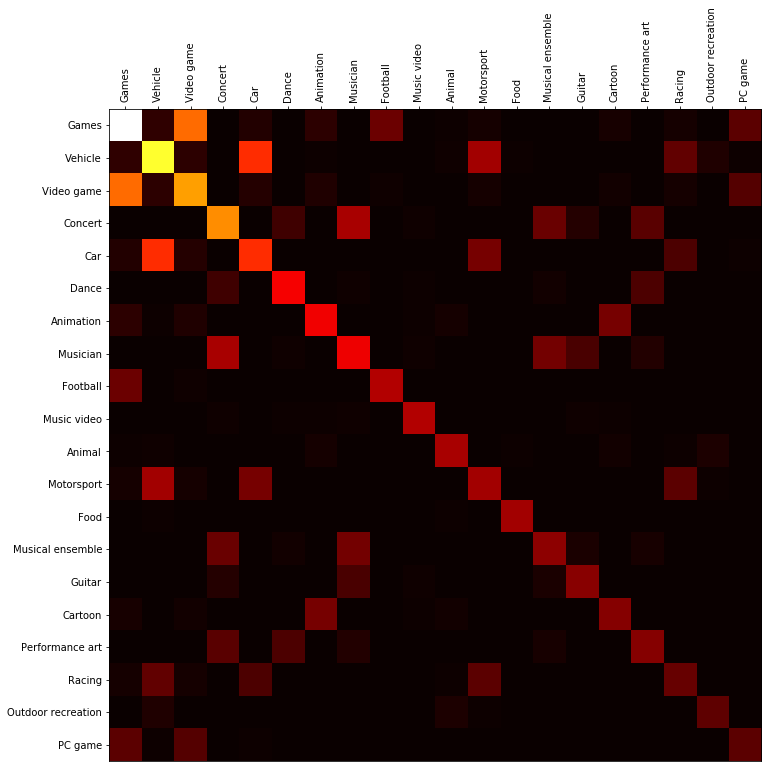

In [30]:
plt.figure(figsize=(12, 12))
plt.imshow(co_mat_dense, cmap='hot', interpolation='nearest')
plt.xticks(range(20), labels['label_name'][:20], rotation='vertical')
plt.yticks(range(20), labels['label_name'][:20], rotation='horizontal')
plt.gca().xaxis.tick_top()
plt.show()

In [56]:
co_mat_dense = co_mat[:100, :100].todense()

In [69]:
co_mat_dense_no_diag = co_mat_dense - np.diag(co_mat_dense) * np.eye(co_mat_dense.shape[0], dtype="uint32")

In [59]:
np.unravel_index(np.argmax(co_mat_dense), dims=co_mat_dense.shape)

(0, 0)

In [120]:
counts = np.diag(co_mat_dense)
counts

array([859519, 678257, 518981, 494707, 371391, 303295, 296624, 295199,
       217920, 214887, 202073, 196804, 195310, 169704, 162048, 161089,
       159726, 119952, 109582, 106519,  96490,  94418,  92185,  89874,
        85567,  84609,  84323,  83730,  83789,  81896,  78544,  73917,
        72524,  72133,  68156,  66591,  63601,  60669,  60124,  59004,
        58713,  58654,  58338,  58481,  57300,  57374,  56559,  55210,
        52328,  52169,  49773,  49379,  49554,  48472,  47320,  47171,
        47048,  45787,  45965,  44648,  43467,  43247,  43063,  42781,
        42650,  42257,  39842,  38538,  38932,  37796,  36455,  36008,
        36163,  35946,  35550,  34729,  34128,  34129,  33904,  33695,
        32913,  32592,  32474,  32171,  32121,  31875,  31944,  30772,
        30933,  30468,  30378,  30461,  30431,  30250,  29719,  29465,
        29313,  29137,  28953,  28944], dtype=uint32)

In [71]:
co_mat_dense

matrix([[859519,  48552, 450313, ...,    547,    112,    842],
        [ 48552, 678257,  44848, ...,    507,    585,    586],
        [450313,  44848, 518981, ...,    268,     49,    476],
        ..., 
        [   547,    507,    268, ...,  29137,     12,    126],
        [   112,    585,     49, ...,     12,  28953,    229],
        [   842,    586,    476, ...,    126,    229,  28944]], dtype=uint32)

In [72]:
co_mat_dense_no_diag

matrix([[     0,  48552, 450313, ...,    547,    112,    842],
        [ 48552,      0,  44848, ...,    507,    585,    586],
        [450313,  44848,      0, ...,    268,     49,    476],
        ..., 
        [   547,    507,    268, ...,      0,     12,    126],
        [   112,    585,     49, ...,     12,      0,    229],
        [   842,    586,    476, ...,    126,    229,      0]], dtype=uint32)

In [73]:
np.unravel_index(np.argmax(co_mat_dense_no_diag), dims=co_mat_dense.shape)

(0, 2)

In [75]:
rowsums = np.sum(co_mat_dense_no_diag, axis=1)

In [127]:
co_percentage = co_mat_dense_no_diag / np.matrix(counts).T
co_percentage

matrix([[  0.00000000e+00,   5.64874075e-02,   5.23912793e-01, ...,
           6.36402453e-04,   1.30305438e-04,   9.79617670e-04],
        [  7.15834853e-02,   0.00000000e+00,   6.61224285e-02, ...,
           7.47504265e-04,   8.62504921e-04,   8.63979288e-04],
        [  8.67686871e-01,   8.64154950e-02,   0.00000000e+00, ...,
           5.16396554e-04,   9.44157879e-05,   9.17181939e-04],
        ..., 
        [  1.87733809e-02,   1.74005560e-02,   9.19792703e-03, ...,
           0.00000000e+00,   4.11847479e-04,   4.32439853e-03],
        [  3.86833834e-03,   2.02051601e-02,   1.69239802e-03, ...,
           4.14464822e-04,   0.00000000e+00,   7.90937036e-03],
        [  2.90906578e-02,   2.02459923e-02,   1.64455500e-02, ...,
           4.35323383e-03,   7.91182974e-03,   0.00000000e+00]])

<Container object of 100 artists>

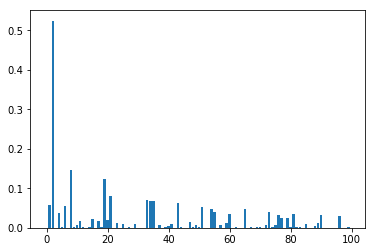

In [128]:
plt.bar(left=range(100), height=np.ravel(co_percentage[0, :]))

<Container object of 100 artists>

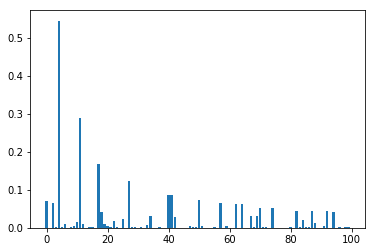

In [129]:
plt.bar(left=range(100), height=np.ravel(co_percentage[1, :]))

<Container object of 100 artists>

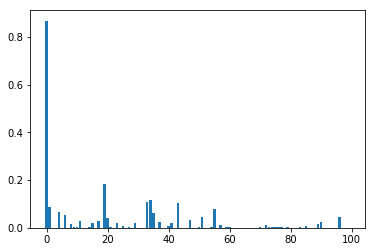

In [130]:
plt.bar(left=range(100), height=np.ravel(co_percentage[2, :]))

<Container object of 100 artists>

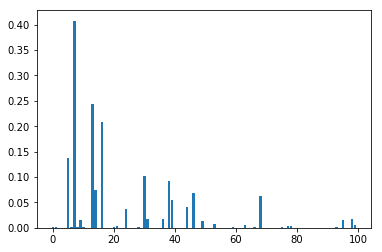

In [131]:
plt.bar(left=range(100), height=np.ravel(co_percentage[3, :]))

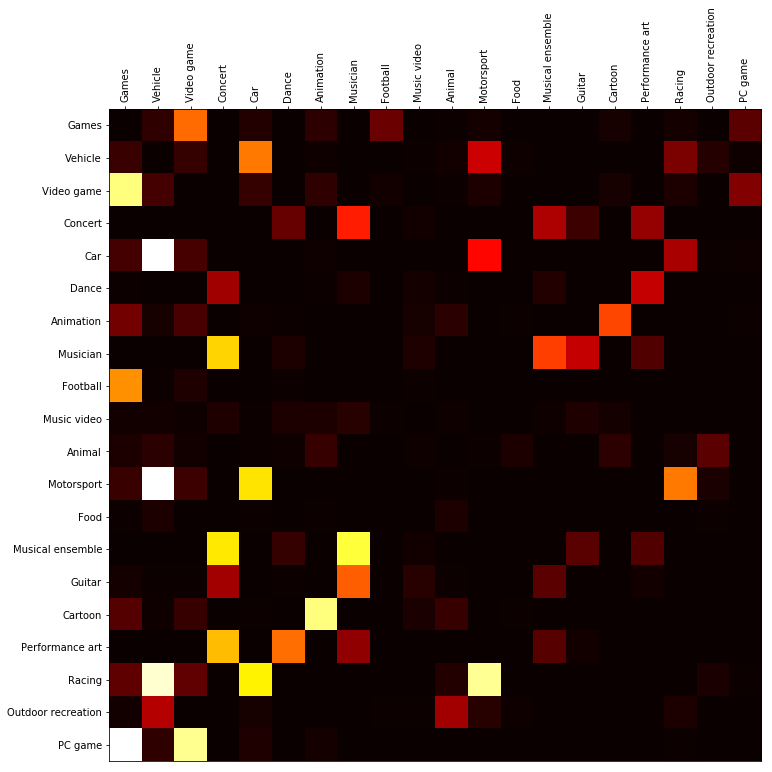

In [132]:
plt.figure(figsize=(12, 12))
plt.imshow(co_percentage[:20, :20], cmap='hot', interpolation='nearest')
plt.xticks(range(20), labels['label_name'][:20], rotation='vertical')
plt.yticks(range(20), labels['label_name'][:20], rotation='horizontal')
plt.gca().xaxis.tick_top()
plt.show()

In [137]:
co_mat_dense_no_diag

matrix([[     0,  48552, 450313, ...,    547,    112,    842],
        [ 48552,      0,  44848, ...,    507,    585,    586],
        [450313,  44848,      0, ...,    268,     49,    476],
        ..., 
        [   547,    507,    268, ...,      0,     12,    126],
        [   112,    585,     49, ...,     12,      0,    229],
        [   842,    586,    476, ...,    126,    229,      0]], dtype=uint32)

In [139]:
counts

array([859519, 678257, 518981, 494707, 371391, 303295, 296624, 295199,
       217920, 214887, 202073, 196804, 195310, 169704, 162048, 161089,
       159726, 119952, 109582, 106519,  96490,  94418,  92185,  89874,
        85567,  84609,  84323,  83730,  83789,  81896,  78544,  73917,
        72524,  72133,  68156,  66591,  63601,  60669,  60124,  59004,
        58713,  58654,  58338,  58481,  57300,  57374,  56559,  55210,
        52328,  52169,  49773,  49379,  49554,  48472,  47320,  47171,
        47048,  45787,  45965,  44648,  43467,  43247,  43063,  42781,
        42650,  42257,  39842,  38538,  38932,  37796,  36455,  36008,
        36163,  35946,  35550,  34729,  34128,  34129,  33904,  33695,
        32913,  32592,  32474,  32171,  32121,  31875,  31944,  30772,
        30933,  30468,  30378,  30461,  30431,  30250,  29719,  29465,
        29313,  29137,  28953,  28944], dtype=uint32)

In [147]:
total = np.repeat(np.matrix(counts), counts.shape[0], axis=0) + np.repeat(np.matrix(counts).T, counts.shape[0], axis=1)
total

matrix([[1719038, 1537776, 1378500, ...,  888656,  888472,  888463],
        [1537776, 1356514, 1197238, ...,  707394,  707210,  707201],
        [1378500, 1197238, 1037962, ...,  548118,  547934,  547925],
        ..., 
        [ 888656,  707394,  548118, ...,   58274,   58090,   58081],
        [ 888472,  707210,  547934, ...,   58090,   57906,   57897],
        [ 888463,  707201,  547925, ...,   58081,   57897,   57888]], dtype=uint32)

In [152]:
co_total_percentage = co_mat_dense_no_diag / total
co_total_percentage

matrix([[  0.00000000e+00,   3.15728689e-02,   3.26668843e-01, ...,
           6.15536271e-04,   1.26059122e-04,   9.47704069e-04],
        [  3.15728689e-02,   0.00000000e+00,   3.74595527e-02, ...,
           7.16715154e-04,   8.27194186e-04,   8.28618738e-04],
        [  3.26668843e-01,   3.74595527e-02,   0.00000000e+00, ...,
           4.88945811e-04,   8.94268288e-05,   8.68732034e-04],
        ..., 
        [  6.15536271e-04,   7.16715154e-04,   4.88945811e-04, ...,
           0.00000000e+00,   2.06576003e-04,   2.16938414e-03],
        [  1.26059122e-04,   8.27194186e-04,   8.94268288e-05, ...,
           2.06576003e-04,   0.00000000e+00,   3.95529993e-03],
        [  9.47704069e-04,   8.28618738e-04,   8.68732034e-04, ...,
           2.16938414e-03,   3.95529993e-03,   0.00000000e+00]])

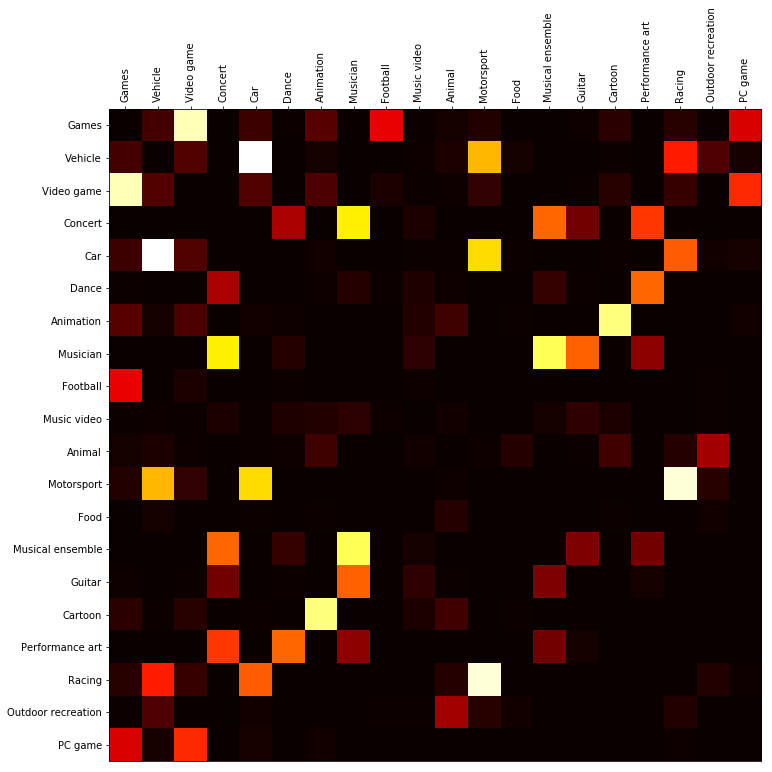

In [153]:
plt.figure(figsize=(12, 12))
plt.imshow(co_total_percentage[:20, :20], cmap='hot', interpolation='nearest')
plt.xticks(range(20), labels['label_name'][:20], rotation='vertical')
plt.yticks(range(20), labels['label_name'][:20], rotation='horizontal')
plt.gca().xaxis.tick_top()
plt.show()

<Container object of 100 artists>

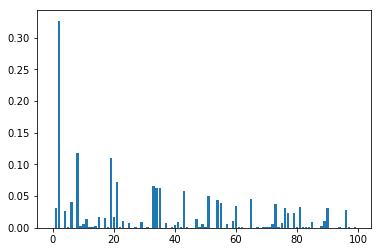

In [154]:
plt.bar(left=range(100), height=np.ravel(co_total_percentage[0, :]))

<Container object of 100 artists>

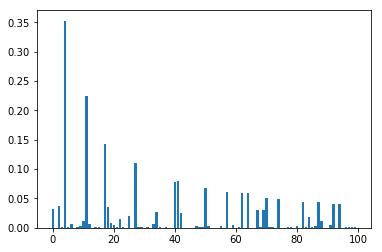

In [155]:
plt.bar(left=range(100), height=np.ravel(co_total_percentage[1, :]))

<Container object of 100 artists>

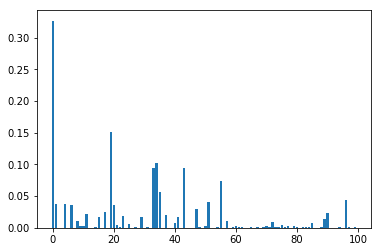

In [156]:
plt.bar(left=range(100), height=np.ravel(co_total_percentage[2, :]))

In [165]:
co_threshhold = (co_total_percentage >= 0.01) * 1
co_threshhold

matrix([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [160]:
pickle.dump(labels, open("labels.pkl", "wb"))

In [163]:
pickle.dump(list(labels['label_name']), open("label_names.pkl", "wb"))

In [166]:
np.transpose(co_threshhold.nonzero())

array([[ 0,  1],
       [ 0,  2],
       [ 0,  4],
       ..., 
       [99, 46],
       [99, 68],
       [99, 84]])